## Calculate heat budget
Using xgcm with metric to demonstrate budget closure. 

This is an image of the POP output structure on the horizontal B-grid: 

<img src="POP_Grid.png" alt="Drawing" style="width: 800px;"/>

### Import packages and define functions

In [2]:
%matplotlib inline

import xarray as xr
import numpy as np
import pop_tools
import matplotlib.pyplot as plt
from tqdm import tqdm

xr.set_options(display_style='html')

def pop_find_lat_ind(loc, LATDAT):
	return np.abs(LATDAT[:,0].values-loc).argmin()

def pop_find_lon_ind(loc, LONDAT, direction='w'):
	if direction.lower() in ['east', 'e']:
		value = loc
	elif direction.lower() in ['west','w']:
		value = 360 - loc
	else:
		print('I do not know which direction.')
	return np.nanargmin(np.abs(LONDAT[152,:].values-value))

### Load Dataset

In [ ]:
# open sample data
filepath = pop_tools.DATASETS.fetch('Pac_POP0.1_JRA_IAF_1993-12-6-test.nc')
ds = xr.open_dataset(filepath)

# get DZU and DZT, needed for operations later on
filepath_g = pop_tools.DATASETS.fetch('Pac_grid_pbc_1301x305x62.tx01_62l.2013-07-13.nc')
ds_g = xr.open_dataset(filepath_g)

ds["DZT"] = ds_g.DZT
ds["DZU"] = ds_g.DZU

In [4]:
# get lola inds from somewhere for indexing later on
lola_inds = {}
inds_lat = [-8,-5,-4,-3,-2,-1,0,1,2,3,4,5,8]
for j in inds_lat:
    if j < 0:
        lola_inds['j_' + str(j)[1:] + 's'] = pop_find_lat_ind(j, ds.TLAT)
    else:
        lola_inds['j_' + str(j) + 'n'] = pop_find_lat_ind(j, ds.TLAT)
        
inds_lon = range(95,185,5)
for i in inds_lon:
    lola_inds['i_' + str(i) + '_w'] = pop_find_lon_ind(i, ds.TLONG)

#### just making sure everything works

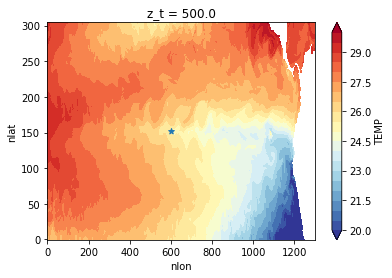

In [5]:
# just making sure everything works
ds.TEMP.isel(z_t=0).mean(dim='time').plot(levels=np.arange(20,30.5,0.5), cmap='RdYlBu_r')
plt.scatter(lola_inds['i_140_w'], lola_inds['j_0n'], marker='*')

#### set up vertical thickness and volume for scaling

In [6]:
ds['DZT'] = ds_dzt.DZT
ds['DZU'] = ds_dzu.DZU
ds.DZT.attrs['long_name'] = 'Thickness of T cells'
ds.DZT.attrs['units'] = 'centimeter'
ds.DZT.attrs['grid_loc'] = '3111'
ds.DZU.attrs['long_name'] = 'Thickness of U cells'
ds.DZU.attrs['units'] = 'centimeter'
ds.DZU.attrs['grid_loc'] = '3221'

# make sure we have the cell volumne for calculations
VOL = (ds.DZT * ds.DXT* ds.DYT).compute()
KMT = ds.KMT.compute()

for j in tqdm(range(len(KMT.nlat))):
    for i in range(len(KMT.nlon)):
        k = KMT.values[j,i].astype(int)
        VOL.values[k:,j,i] = 0.

ds['VOL']=VOL

ds.VOL.attrs['long_name'] = 'volume of T cells'
ds.VOL.attrs['units'] = 'centimeter^3'

ds.VOL.attrs['grid_loc'] = '3111'

100%|██████████| 305/305 [00:01<00:00, 253.66it/s]


In [7]:
# here we get the xgcm compatible dataset 
gridx, dsx = pop_tools.to_xgcm_grid_dataset(ds)

for coord in ['nlat', 'nlon']:
    if coord in dsx.coords:
        dsx = dsx.drop_vars(coord)

# this is necessary to make things multiply that otherwise would not        
if 'z_w_top' and 'z_w' in dsx.dims:
    dsx = dsx.drop('z_w_top').rename({'z_w': 'z_w_top'})
    
dsi = to_index(dsx)

## using xgcm with metrics

#### Set up dataset to gather budget terms

In [8]:
dm = xr.Dataset()

#### set grid and data set for xgcm with metrics

In [15]:
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"]}

gridxgcm, dsxgcm = pop_tools.to_xgcm_grid_dataset(ds, periodic=False, metrics=metrics)

#### 0) Tendency

In [16]:
dm['TEND_TEMP'] = dsxgcm.TEND_TEMP

#### i) Total heat advection

In [17]:
dm['UET'] = -(gridxgcm.diff(dsxgcm.UET * dsxgcm.VOL.values, axis="X", boundary="extend")
              /
              dsxgcm.VOL)
dm['VNT'] = -(gridxgcm.diff(dsxgcm.VNT * dsxgcm.VOL.values, axis="Y", boundary="extend")
              /
              dsxgcm.VOL)
dm['WTT'] = (gridxgcm.diff(dsxgcm.WTT.fillna(0) * (dsxgcm.dz * dsxgcm.DXT * dsxgcm.DYT).values,
                           axis="Z", boundary="extend")
             /
             dsxgcm.VOL)
dm['TOT_ADV'] = dm['UET'] + dm['VNT'] + dm['WTT']

#### ii) Heat flux due to vertical mixing:
includes surface flux at the 0th layer

In [18]:
dm['DIA_IMPVF_TEMP'] =  -(gridxgcm.diff(dsxgcm.DIA_IMPVF_TEMP * dsxgcm.TAREA, axis="Z", boundary="extend")
                           /
                           dsxgcm.VOL)
dm['DIA_IMPVF_TEMP'] = dm['DIA_IMPVF_TEMP'].load()

# set surface flux at 0th layer
SRF_TEMP_FLUX = (dsx.SHF - dsx.SHF_QSW) * dsx.hflux_factor 

dm['DIA_IMPVF_TEMP'][:,0,:,:]=((SRF_TEMP_FLUX * dsxgcm.TAREA  
                                -
                                dsxgcm.DIA_IMPVF_TEMP.isel(z_w_bot=0) * dsxgcm.TAREA)
                               /
                               dsxgcm.VOL.values[0,:,:])

dm['KPP_SRC_TMP'] = dsxgcm.KPP_SRC_TEMP
dm['VDIF'] = dm['DIA_IMPVF_TEMP'] + dm['KPP_SRC_TMP']

#### iii) Heat flux due to horizontal diffusion

In [19]:
dm['HDIFE_TEMP'] = (gridxgcm.diff(dsxgcm.HDIFE_TEMP * dsxgcm.VOL.values, axis="X", boundary="extend")
                    /
                    dsxgcm.VOL)
dm['HDIFN_TEMP'] = (gridxgcm.diff(dsxgcm.HDIFN_TEMP * dsxgcm.VOL.values, axis="Y", boundary="extend")
                    /
                    dsxgcm.VOL)
dm['HDIF'] = dm['HDIFE_TEMP'] + dm['HDIFN_TEMP']

#### iv) Solar Penetration

In [20]:
dm['QSW_3D'] = (-gridxgcm.diff((dsxgcm.QSW_3D * dsxgcm.hflux_factor), axis="Z", boundary="extend")
                /
                dsxgcm.DZT)

#### plot to make sure it closes

CPU times: user 3.32 s, sys: 5.01 s, total: 8.33 s
Wall time: 24.6 s


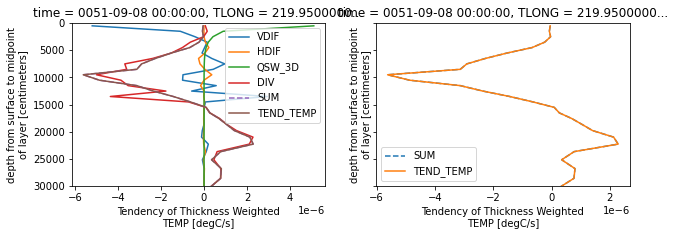

In [21]:
%%time

fig, ax = plt.subplots(1,2,figsize=(10,3), sharey=True)

# plot individual components
dm.VDIF.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='VDIF', ax=ax[0])
dm.HDIF.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='HDIF', ax=ax[0])
dm.QSW_3D.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='QSW_3D', ax=ax[0])
dm.TOT_ADV.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='DIV', ax=ax[0])

# plot sum 
((dm.QSW_3D + dm.HDIF + dm.VDIF + dm.TOT_ADV)
 .isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0)).plot(y='z_t', ylim=(300e2,0),
                                                                            label='SUM', ls='--', ax=ax[0])
# plot tendency
dm.TEND_TEMP.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='TEND_TEMP', ax=ax[0])

ax[0].legend()

# plot sum 
((dm.QSW_3D + dm.HDIF + dm.VDIF + dm.TOT_ADV)
 .isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0)).plot(y='z_t', ylim=(300e2,0),
                                                                            label='SUM', ls='--', ax=ax[1])
# plot tendency
dm.TEND_TEMP.isel(nlon_t=lola_inds['i_140_w'], nlat_t=lola_inds['j_0n'], time=0).plot(y='z_t', ylim=(300e2,0),
                                                                                 label='TEND_TEMP', ax=ax[1])

ax[1].legend()

In [25]:
# You may need to install watermark (conda install -c conda-forge watermark)
%load_ext watermark
%watermark -d -iv -m -g -h
print('Above are the versions of the packages this works with.')

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1127.18.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 72
Architecture: 64bit

Hostname: casper12

Git hash: HEAD

ncar_jobqueue: 2020.3.4
dask         : 2021.2.0
numpy        : 1.19.5
xarray       : 0.17.0
distributed  : 2021.2.0
pop_tools    : 2020.9.14
matplotlib   : 3.2.2

Above are the versions of the packages this works with.
